In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR

# 경고메시지 무시
import warnings
warnings.filterwarnings("ignore")

출처 : https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx

# 전처리

In [2]:
# 데이터 불러오기

data = pd.read_csv('data/add_barrel_rate.csv')   

In [3]:
data

,월별,선수명,타수,안타,1루타,2루타,3루타,홈런,사사구,득점,희생플라이,선수코드,배럴률
0,201803,강백호,27,10,4,2,0,4,3,7,0,68050,0.250000
1,201803,김재환,25,5,3,0,0,2,3,5,1,78224,0.285714
2,201803,김현수,29,7,4,2,0,1,3,5,0,76290,0.105263
3,201803,로맥,26,10,7,0,0,3,5,9,0,67872,0.214286
4,201803,박건우,30,9,7,1,1,0,1,5,0,79215,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,202107,양의지,17,5,3,1,0,1,1,1,2,76232,0.133333
249,202107,이정후,23,9,8,1,0,0,7,5,0,67341,0.050000
250,202107,전준우,27,9,5,4,0,0,3,6,0,78513,0.000000
251,202107,채은성,13,4,2,2,0,0,3,3,1,79192,0.153846


In [4]:
# 배럴률을 백분율로 환산

data['배럴률'] = data['배럴률'] * 100

In [5]:
# '월별' 특성을 날짜 형식으로 바꾸기

data['월별'] = data['월별'].astype(str)
data['월별'] = data['월별'].str[0:4] + '-' + data['월별'].str[4:6]

In [6]:
# OPS 값이 0 인 데이터 확인

data_ops = data.copy()

data_ops['안타'] = data_ops['1루타']+data_ops['2루타']+data_ops['3루타']+data_ops['홈런']
data_ops['장타율'] = (data_ops['1루타']+(data_ops['2루타']*2)+(data_ops['3루타']*3)+(data_ops['홈런']*4)) / data_ops['타수']
data_ops['출루율'] = (data_ops['안타']+data_ops['사사구']) / (data_ops['타수']+data_ops['사사구']+data_ops['희생플라이'])
data_ops['OPS'] = data_ops['장타율'] + data_ops['출루율']

data_ops[data_ops['OPS']==0]

,월별,선수명,타수,안타,1루타,2루타,3루타,홈런,사사구,득점,희생플라이,선수코드,배럴률,장타율,출루율,OPS
59,2018-08,최정,6,0,0,0,0,0,0,0,0,75847,33.333333,0.0,0.0,0.0
62,2018-09,김현수,2,0,0,0,0,0,0,0,0,76290,0.000000,0.0,0.0,0.0
152,2019-10,전준우,3,0,0,0,0,0,0,1,0,78513,0.000000,0.0,0.0,0.0


In [7]:
# OPS 값이 0인 데이터 제거

print("제거 전 shape :", data.shape)

data.drop(data[(data['선수명']=='최정') & (data['월별']=='2018-08')].index,inplace=True)
data.drop(data[(data['선수명']=='김현수') & (data['월별']=='2018-09')].index,inplace=True)
data.drop(data[(data['선수명']=='전준우') & (data['월별']=='2019-10')].index,inplace=True)

print("제거 후 shape :", data.shape)

제거 전 shape : (253, 13)
제거 후 shape : (250, 13)


In [8]:
# 불필요한 특성 제거

data.index = data['월별']
data = data.drop('월별',axis=1)

In [9]:
# 설명변수 나누기

data_ja = data[['1루타','2루타','3루타','홈런','득점','배럴률','선수명']]
data_mo = data[['타수','사사구','희생플라이','선수명']]

In [10]:
# 20개 데이터셋 생성 10명 * 특성 2세트(data_ja, data_mo)

for i in range(10):
    globals()['data{}'.format(i)] = data_ja[data_ja['선수명'] == data_ja['선수명'].unique()[i]]
    globals()['data{}'.format(i)].drop('선수명', axis=1, inplace=True)
    
for i in range(10,20):
    globals()['data{}'.format(i)] = data_mo[data_mo['선수명'] == data_mo['선수명'].unique()[i-10]]
    globals()['data{}'.format(i)].drop('선수명', axis=1, inplace=True)

# 모델링

In [11]:
# VAR 모델 생성

for i in range(20):
    globals()['model{}'.format(i)] = VAR(globals()['data{}'.format(i)]).fit()

# 예측

In [12]:
for i in range(20):
    globals()['pred{}'.format(i)] = globals()['model{}'.format(i)].forecast(globals()['data{}'.format(i)].values, steps=3)
    globals()['pred{}'.format(i)] = pd.DataFrame(globals()['pred{}'.format(i)])

In [13]:
for i in range(10):
    globals()['pred_df{}'.format(i)] = pd.concat([globals()['pred{}'.format(i)],globals()['pred{}'.format(i+10)]],axis=1)
    globals()['pred_df{}'.format(i)].columns = ['1루타','2루타','3루타','홈런','득점','배럴률','타수','사사구','희생플라이']

In [14]:
pred = pd.concat([pred_df0,pred_df1,pred_df2,pred_df3,pred_df4,
                  pred_df5,pred_df6,pred_df7,pred_df8,pred_df9])

In [15]:
pred['안타'] = pred['1루타']+pred['2루타']+pred['3루타']+pred['홈런']
pred['장타율'] = (pred['1루타']+(pred['2루타']*2)+(pred['3루타']*3)+(pred['홈런']*4)) / pred['타수']
pred['출루율'] = (pred['안타']+pred['사사구']) / (pred['타수']+pred['사사구']+pred['희생플라이'])
pred['OPS'] = pred['장타율'] + pred['출루율']

pred = pred[['OPS','장타율','출루율']]

In [16]:
# 20210915 ~ 20211008 OPS 예측
# 9월*14/21 + 10월*7/21 로 최종 OPS 계산

pred10 = pd.DataFrame()

for i in range(0, 30, 3):
    pred10 = pred10.append(pd.DataFrame(pred.iloc[i+1,:]*14/21 + pred.iloc[i+2,:]*7/21).T)


# 제출 파일 생성

In [17]:
PCODE = [68050, 78224, 76290, 67872, 79215,
         76232, 67341, 78513, 79192, 75847]

pred10['PCODE'] = PCODE

pred10.reset_index(drop=True,inplace=True)

pred10 = pred10.reindex(index=[5,0,9,6,8,1,7,2,4,3])

pred10['NO.'] = [1,2,3,4,5,6,7,8,9,10]

pred10.reset_index(drop=True,inplace=True)

pred10 = pred10[['NO.','PCODE','OPS','장타율','출루율']]

pred10

,NO.,PCODE,OPS,장타율,출루율
0,1,76232,0.995774,0.572739,0.423035
1,2,68050,0.841150,0.469830,0.371320
2,3,75847,1.008615,0.593741,0.414873
3,4,67341,0.873131,0.471251,0.401880
4,5,79192,0.847945,0.488704,0.359242
5,6,78224,0.976023,0.580061,0.395962
6,7,78513,0.818339,0.449584,0.368755
7,8,76290,0.902504,0.522329,0.380175
8,9,79215,0.930486,0.517072,0.413414
9,10,67872,0.950169,0.555126,0.395043


In [19]:
pred10.to_excel('data/데이터분석분야_챔피언리그_스포츠테크_운수영원_평가데이터.xlsx',index=False)

# 시각화

In [20]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [21]:
# 예측한 8, 9, 10월 OPS 불러오기

pred['선수명'] = ['강백호']*3 + ['김재환']*3 + ['김현수']*3 + ['로맥']*3 + ['박건우']*3 + ['양의지']*3 + ['이정후']*3 + ['전준우']*3 + ['채은성']*3 + ['최정']*3
pred['월별'] = ['2021-08','2021-09','2021-10'] * 10

pred = pred[['월별','선수명','OPS']]

In [22]:
# 시각화에 필요한 변수 추출

pred_08 = pred[pred['월별']=='2021-08']
data_ops = data_ops.append(pred_08,ignore_index=True)
data_ops.fillna(0,inplace=True)
data_ops['선수코드'] = data_ops['선수코드'].astype('int64')

In [23]:
# 선수명 기준으로 ops 데이터 분할

# 2018 ~ 2021-07
for i in range(10):
    globals()['ops{}'.format(i)] = data_ops[data_ops['선수명'] == data_ops['선수명'].unique()[i]]
    globals()['ops{}'.format(i)] = globals()['ops{}'.format(i)][['월별','OPS']]
    
# 2021-09 ~ 2021-10
for i in range(10):
    globals()['pred{}'.format(i)] = pred[pred['선수명'] == data_ops['선수명'].unique()[i]] 
    globals()['pred{}'.format(i)] = globals()['pred{}'.format(i)][['월별','OPS']]

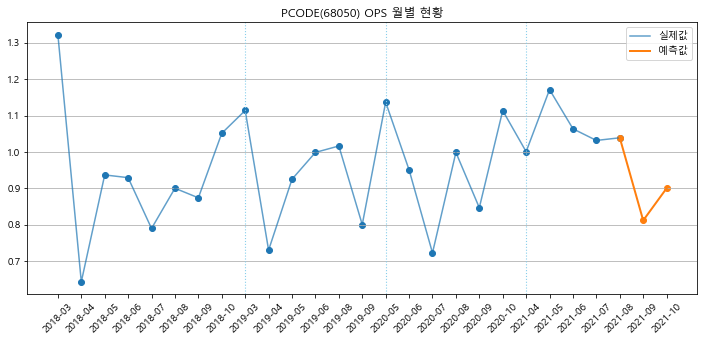

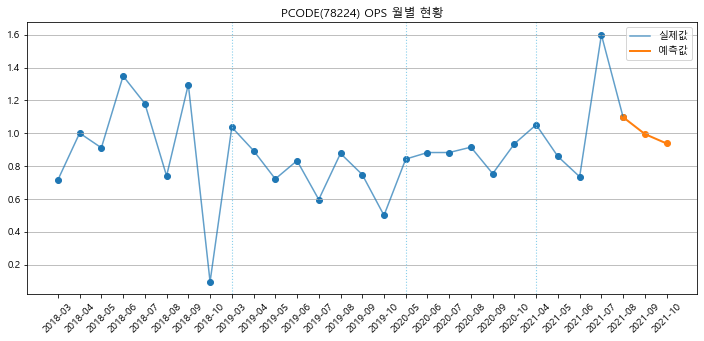

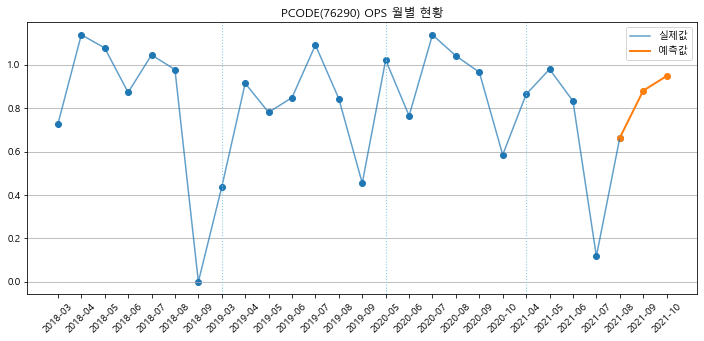

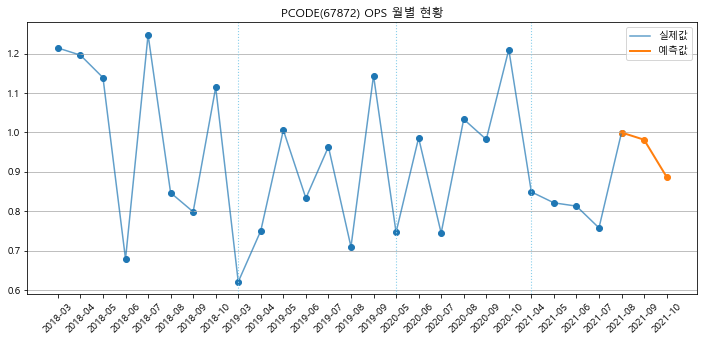

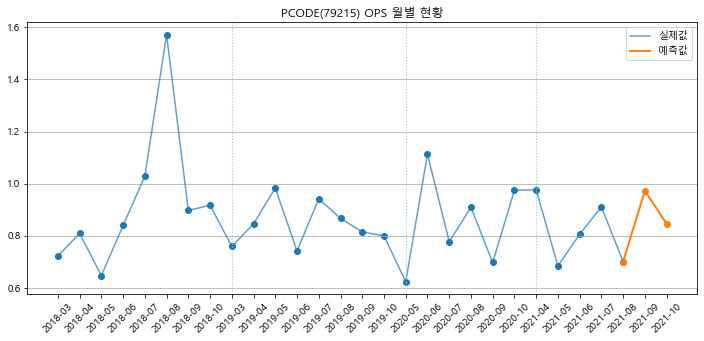

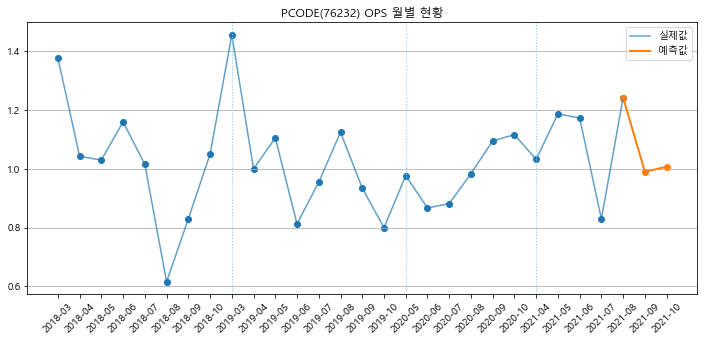

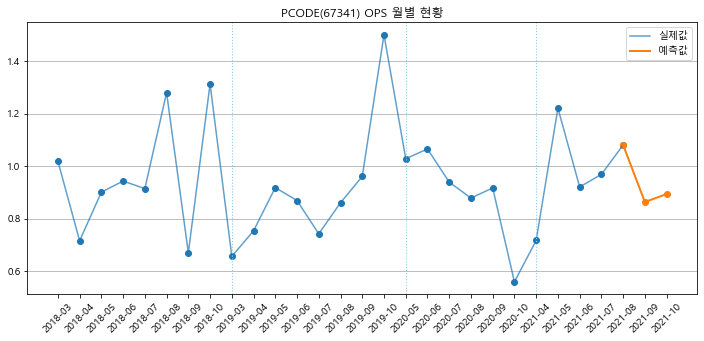

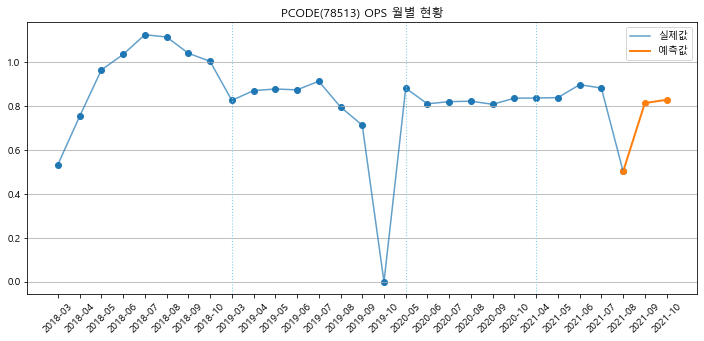

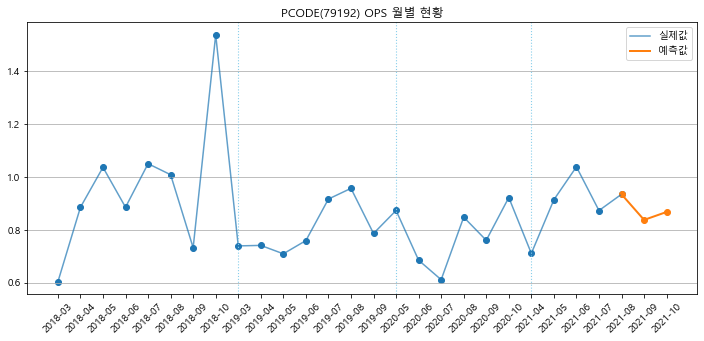

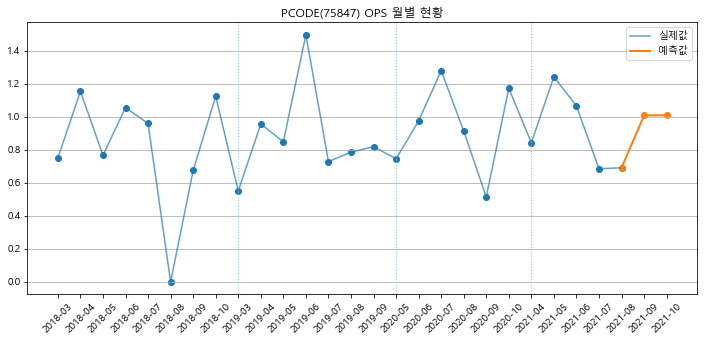

In [24]:
# 타자별 OPS 현황 시각화

for i in range(10):
    plt.figure(figsize=(12,5))
    plt.scatter(globals()['ops{}'.format(i)]['월별'], globals()['ops{}'.format(i)]['OPS'])
    plt.plot(globals()['ops{}'.format(i)]['월별'], globals()['ops{}'.format(i)]['OPS'],alpha=0.7,label='실제값')
    plt.xticks(rotation=45)
    plt.axvline(x=('2019-03'), color='skyblue', linestyle=':', linewidth=1.1)
    plt.axvline(x=('2020-05'), color='skyblue', linestyle=':', linewidth=1.1)
    plt.axvline(x=('2021-04'), color='skyblue', linestyle=':', linewidth=1.1)
    plt.title("PCODE({}) OPS 월별 현황".format(data_ops['선수코드'].unique()[i]))
    plt.grid(axis='y')
    plt.scatter(globals()['pred{}'.format(i)]['월별'], globals()['pred{}'.format(i)]['OPS'])
    plt.plot(globals()['pred{}'.format(i)]['월별'], globals()['pred{}'.format(i)]['OPS'],linewidth=2,label='예측값')
    plt.legend()
    plt.show()